In [1]:
import uproot
from pathlib import Path
import requests
from tqdm import tqdm
import numpy as np
from typing import Dict, List, Optional

class ATLASDataManager:
    def __init__(self, base_dir: str = "atlas_data"):
        """Initialize the data manager with a base directory."""
        self.base_dir = Path(base_dir)
        self.base_url = "https://opendata.cern.ch/record/80001/files"
        self._setup_directories()
        
    def _setup_directories(self):
        """Create necessary directory structure."""
        # Main data directory
        self.base_dir.mkdir(exist_ok=True)
        # Directory for run catalogs
        (self.base_dir / "catalogs").mkdir(exist_ok=True)
        # Directory for PHYSLITE data
        (self.base_dir / "physlite").mkdir(exist_ok=True)
        
    def _download_file(self, url: str, output_path: Path, desc: str = None) -> bool:
        """Download a single file if it doesn't exist."""
        if output_path.exists():
            return False
            
        print(f"downloading file: https://opendata.cern.ch{url}")   
        response = requests.get(f"https://opendata.cern.ch{url}", stream=True)
        if response.status_code == 200:
            total_size = int(response.headers.get('content-length', 0))
            
            with open(output_path, 'wb') as f, tqdm(
                desc=desc,
                total=total_size,
                unit='iB',
                unit_scale=True,
                unit_divisor=1024,
            ) as pbar:
                for data in response.iter_content(chunk_size=1024):
                    size = f.write(data)
                    pbar.update(size)
            return True
        else:
            raise Exception(f"Download failed with status code: {response.status_code}")
    
    def download_run_catalog(self, run_number: str, index: int = 0) -> bool:
        """Download a specific run catalog file."""
        url = f"/record/80001/files/data16_13TeV_Run_{run_number}_file_index.json_{index}"
        output_path = self.base_dir / "catalogs" / f"Run_{run_number}_catalog_{index}.root"
        return self._download_file(url, output_path, f"Downloading catalog {index} for Run {run_number}")
    
    def examine_catalog(self, run_number: str, index: int = 0):
        """Examine contents of a run catalog file."""
        catalog_path = self.base_dir / "catalogs" / f"Run_{run_number}_catalog_{index}.root"
        if not catalog_path.exists():
            print(f"Catalog file not found: {catalog_path}")
            return
        
        try:
            with uproot.open(catalog_path) as file:
                print(f"Contents of Run {run_number} catalog {index}:")
                for key in file.keys():
                    try:
                        obj = file[key]
                        print(f"\nObject {key}:")
                        print(f"Type: {type(obj)}")
                        print(f"Info: {obj}")
                    except Exception as e:
                        print(f"Couldn't read {key}: {str(e)}")
        except Exception as e:
            print(f"Error examining catalog: {str(e)}")
    
    def get_stats(self) -> Dict:
        """Get statistics about downloaded files."""
        stats = {
            "catalogs": len(list((self.base_dir / "catalogs").glob("*.root"))),
            "physlite_files": len(list((self.base_dir / "physlite").glob("*.root"))),
            "total_size": sum(f.stat().st_size for f in self.base_dir.rglob("*.*")) / (1024 * 1024 * 1024)  # in GB
        }
        return stats
    
    def print_status(self):
        """Print current status of downloads."""
        stats = self.get_stats()
        print(f"=== ATLAS Data Status ===")
        print(f"Number of run catalogs: {stats['catalogs']}")
        print(f"Number of PHYSLITE files: {stats['physlite_files']}")
        print(f"Total data size: {stats['total_size']:.2f} GB")

In [2]:
# Initialize manager
data_mgr = ATLASDataManager()

# Download a run catalog
data_mgr.download_run_catalog("00296939", 0)

# Examine its contents
data_mgr.examine_catalog("00296939", 0)

# Check status
data_mgr.print_status()

Contents of Run 00296939 catalog 0:

Object ##Params;3:
Type: <class 'uproot.models.TTree.Model_TTree_v20'>
Info: <TTree '##Params' (2 branches) at 0x7f44b04f0fd0>

Object ##Params;2:
Type: <class 'uproot.models.TTree.Model_TTree_v20'>
Info: <TTree '##Params' (2 branches) at 0x7f44b04f5e80>

Object ##Shapes;3:
Type: <class 'uproot.models.TTree.Model_TTree_v20'>
Info: <TTree '##Shapes' (2 branches) at 0x7f44b04807f0>

Object ##Shapes;2:
Type: <class 'uproot.models.TTree.Model_TTree_v20'>
Info: <TTree '##Shapes' (2 branches) at 0x7f44b04e2880>

Object ##Links;3:
Type: <class 'uproot.models.TTree.Model_TTree_v20'>
Info: <TTree '##Links' (2 branches) at 0x7f44b0489100>

Object ##Links;2:
Type: <class 'uproot.models.TTree.Model_TTree_v20'>
Info: <TTree '##Links' (2 branches) at 0x7f44b0479190>

Object MetaData;1:
Type: <class 'uproot.models.TTree.Model_TTree_v20'>
Info: <TTree 'MetaData' (26 branches) at 0x7f4450f28190>

Object MetaDataHdr;1:
Type: <class 'uproot.models.TTree.Model_TTree_v2

In [3]:
def extract_metadata(catalog_path):
    """
    Extract PHYSLITE file references from a catalog ROOT file
    Returns a list of file references
    """
    try:
        with uproot.open(catalog_path) as file:
            if "MetaData;1" in file:
                metadata = file["MetaData;1"]
                print("Found MetaData tree")
                print("\nBranches:")
                for i, branch in enumerate(metadata.keys(), 1):
                    print(f"{i}. {branch}")
                
                # Let's look at a few selected branches first
                # We can add more specific branch examination based on what we find
                print("\nSample of first few entries from selected branches:")
                for i, branch in enumerate(metadata.keys(), 1):
                    try:
                        data = metadata[branch].array()
                        print(f"\n {i}.  Branch: {branch}")
                        print("Type of data:", type(data))
                        print("Data (truncated)", str(data)[:200])
                    except Exception as e:
                        print(f"\n {i}.  Couldn't read branch {branch}: {str(e)}")
                        
    except Exception as e:
        print(f"Error examining catalog: {str(e)}")

# Try it on one catalog file
catalog_path = "atlas_data/catalogs/Run_00296939_catalog_0.root"
extract_metadata(catalog_path)

Found MetaData tree

Branches:
1. FileMetaDataAux.
2. FileMetaDataAux./FileMetaDataAux.xAOD::AuxInfoBase
3. FileMetaDataAux./FileMetaDataAux.productionRelease
4. FileMetaDataAux./FileMetaDataAux.dataType
5. FileMetaDataAux./FileMetaDataAux.runNumbers
6. FileMetaDataAux./FileMetaDataAux.lumiBlocks
7. TriggerMenuJson_HLTAux.
8. TriggerMenuJson_HLTAux./TriggerMenuJson_HLTAux.xAOD::AuxContainerBase
9. TriggerMenuJson_HLTAux./TriggerMenuJson_HLTAux.key
10. TriggerMenuJson_HLTAux./TriggerMenuJson_HLTAux.name
11. TriggerMenuJson_HLTAux./TriggerMenuJson_HLTAux.payload
12. TriggerMenuJson_HLTPSAux.
13. TriggerMenuJson_HLTPSAux./TriggerMenuJson_HLTPSAux.xAOD::AuxContainerBase
14. TriggerMenuJson_HLTPSAux./TriggerMenuJson_HLTPSAux.key
15. TriggerMenuJson_HLTPSAux./TriggerMenuJson_HLTPSAux.name
16. TriggerMenuJson_HLTPSAux./TriggerMenuJson_HLTPSAux.payload
17. TriggerMenuJson_L1Aux.
18. TriggerMenuJson_L1Aux./TriggerMenuJson_L1Aux.xAOD::AuxContainerBase
19. TriggerMenuJson_L1Aux./TriggerMenuJson_L

In [4]:
def explore_collection_tree(catalog_path):
    """
    Explore the structure and contents of the CollectionTree in a ROOT file.
    
    Args:
        catalog_path (str): Path to the ROOT file
    """
    try:
        with uproot.open(catalog_path) as file:
            if "CollectionTree;1" not in file:
                print("No CollectionTree found in file")
                return
                
            tree = file["CollectionTree;1"]
            print(f"\nCollectionTree contains {len(tree)} entries")
            
            # Get all branch names
            branches = tree.keys()
            print(f"\nTotal number of branches: {len(branches)}")

            # Print all branch names enumerated
            for i, branch in enumerate(branches, 1):
                print(f"{i}. {branch}")
            
            # Group branches by type/category based on common prefixes
            branch_groups = {}
            for branch in branches:
                # Split on first dot or underscore
                prefix = branch.split('.')[0].split('_')[0]
                if prefix not in branch_groups:
                    branch_groups[prefix] = []
                branch_groups[prefix].append(branch)
            
            # Print branch groups and their sizes
            print("\nBranch groups found:")
            for prefix, group in sorted(branch_groups.items()):
                print(f"\n{prefix}: {len(group)} branches")
                # Print first few branches in each group
                for branch in sorted(group)[:5]:
                    try:
                        # Try to get the type and shape of the branch
                        array = tree[branch].array()
                        print(f"  - {branch}")
                        print(f"    Type: {type(array)}")
                        print(f"    Shape/Length: {len(array)}")
                        # Try to show a sample value from first event if possible
                        try:
                            sample = array[0]
                            print(f"    First event sample: {str(sample)[:100]}")
                        except:
                            pass
                    except Exception as e:
                        print(f"  - {branch} (Could not read: {str(e)})")
                if len(group) > 5:
                    print(f"  ... and {len(group)-5} more branches")
                    
    except Exception as e:
        print(f"Error examining CollectionTree: {str(e)}")

# Try it on the catalog file
catalog_path = "atlas_data/catalogs/Run_00296939_catalog_0.root"
explore_collection_tree(catalog_path)


CollectionTree contains 790 entries

Total number of branches: 867
1. xTrigDecisionAux.
2. xTrigDecisionAux./xTrigDecisionAux.xAOD::AuxInfoBase
3. xTrigDecisionAux./xTrigDecisionAux.smk
4. xTrigDecisionAux./xTrigDecisionAux.bgCode
5. xTrigDecisionAux./xTrigDecisionAux.tav
6. xTrigDecisionAux./xTrigDecisionAux.tap
7. xTrigDecisionAux./xTrigDecisionAux.tbp
8. xTrigDecisionAux./xTrigDecisionAux.lvl2ErrorBits
9. xTrigDecisionAux./xTrigDecisionAux.efErrorBits
10. xTrigDecisionAux./xTrigDecisionAux.lvl2Truncated
11. xTrigDecisionAux./xTrigDecisionAux.efTruncated
12. xTrigDecisionAux./xTrigDecisionAux.lvl2PassedPhysics
13. xTrigDecisionAux./xTrigDecisionAux.efPassedPhysics
14. xTrigDecisionAux./xTrigDecisionAux.lvl2PassedRaw
15. xTrigDecisionAux./xTrigDecisionAux.efPassedRaw
16. xTrigDecisionAux./xTrigDecisionAux.lvl2PassedThrough
17. xTrigDecisionAux./xTrigDecisionAux.efPassedThrough
18. xTrigDecisionAux./xTrigDecisionAux.lvl2Prescaled
19. xTrigDecisionAux./xTrigDecisionAux.efPrescaled
20. 

In [3]:
import numpy as np
def extract_track_data(file_path):
    """
    Extract track information from ATLAS PHYSLITE data.
    
    Args:
        file_path (str): Path to ROOT file
    Returns:
        dict: Dictionary containing track parameters and arrays
    """
    try:
        with uproot.open(file_path) as file:
            tree = file["CollectionTree;1"]
            
            # Track parameters we want to extract
            track_branches = [
                "InDetTrackParticlesAuxDyn.d0",
                "InDetTrackParticlesAuxDyn.z0",
                "InDetTrackParticlesAuxDyn.phi",
                "InDetTrackParticlesAuxDyn.theta",
                "InDetTrackParticlesAuxDyn.qOverP",
                "InDetTrackParticlesAuxDyn.chiSquared",
                "InDetTrackParticlesAuxDyn.numberDoF",
                "InDetTrackParticlesAuxDyn.definingParametersCovMatrixDiag"
            ]
            
            # Initialize dictionary to store track data
            track_data = {}
            
            # Read each branch using numpy arrays
            for branch in track_branches:
                try:
                    # Extract the parameter name from the branch name
                    param_name = branch.split('.')[-1]
                    track_data[param_name] = tree[branch].array(library="np")
                    
                    # Print some basic statistics
                    if len(track_data[param_name]) > 0:
                        print(f"\n{param_name}:")
                        print(f"  Number of entries: {len(track_data[param_name])}")
                        print(f"  First few values: {track_data[param_name][:5]}")
                except Exception as e:
                    print(f"Could not read branch {branch}: {str(e)}")
            
            # Calculate derived quantities
            if 'qOverP' in track_data:
                # Convert q/p to pT (transverse momentum)
                # Note: This is a simplified conversion
                track_data['pT'] = abs(1.0 / track_data['qOverP']) * np.sin(track_data['theta'])
                
            if 'chiSquared' in track_data and 'numberDoF' in track_data:
                # Calculate chi2/ndof
                track_data['chi2_per_ndof'] = track_data['chiSquared'] / track_data['numberDoF']
            
            return track_data
            
    except Exception as e:
        print(f"Error processing file: {str(e)}")
        return None

def analyze_tracks(track_data):
    """
    Perform basic analysis on the extracted track data.
    
    Args:
        track_data (dict): Dictionary containing track parameters
    """
    if track_data is None:
        return
        
    print("\nTrack Analysis Summary:")
    
    for param, values in track_data.items():
        if len(values) > 0:
            print(f"\n{param}:")
            try:
                # Calculate basic statistics
                mean = np.mean(values)
                median = np.median(values)
                std = np.std(values)
                
                print(f"  Mean: {mean:.4f}")
                print(f"  Median: {median:.4f}")
                print(f"  Std Dev: {std:.4f}")
                # print(f"  Range: [{np.min(values):.4f}, {np.max(values):.4f}]")
            except Exception as e:
                print(f"  Could not calculate statistics: {str(e)}")

# Run the analysis
file_path = "atlas_data/catalogs/Run_00296939_catalog_0.root"
track_data = extract_track_data(file_path)
analyze_tracks(track_data)


d0:
  Number of entries: 12352
  First few values: [array([], dtype=float32) array([-0.0716477], dtype=float32)
 array([-0.04982265, -0.16506408], dtype=float32)
 array([-0.05006231, -0.03200515], dtype=float32) array([], dtype=float32)]

z0:
  Number of entries: 12352
  First few values: [array([], dtype=float32) array([66.70478], dtype=float32)
 array([34.215153, 34.318176], dtype=float32)
 array([28.545576, 28.482952], dtype=float32) array([], dtype=float32)]

phi:
  Number of entries: 12352
  First few values: [array([], dtype=float32) array([-0.15316485], dtype=float32)
 array([-0.42112437, -0.31479055], dtype=float32)
 array([-2.0316765, -1.9575816], dtype=float32) array([], dtype=float32)]

theta:
  Number of entries: 12352
  First few values: [array([], dtype=float32) array([0.34525588], dtype=float32)
 array([2.4879005, 2.5871496], dtype=float32)
 array([1.5983181, 1.5416944], dtype=float32) array([], dtype=float32)]

qOverP:
  Number of entries: 12352
  First few values: [ar

In [6]:
def analyze_pt_calculation(track_data: Dict[str, np.ndarray]) -> None:
    """
    Analyze the pT calculation to identify potential numerical issues
    """
    qOverP = track_data['qOverP']
    theta = track_data['theta']
    
    # Calculate pT
    pT = np.abs(1.0 / qOverP) * np.sin(theta)
    
    # Find extreme pT values
    high_pt_mask = pT > 1000  # Look at tracks above 1 TeV
    
    print("\nAnalyzing pT calculation:")
    print(f"Total tracks: {len(pT)}")
    print(f"Tracks with pT > 1 TeV: {np.sum(high_pt_mask)}")
    print("\nqOverP distribution for high-pT tracks:")
    print(f"  min: {np.min(np.abs(qOverP[high_pt_mask])):.2e}")
    print(f"  max: {np.max(np.abs(qOverP[high_pt_mask])):.2e}")
    
    return pT

def calculate_pt_with_units(qOverP: np.ndarray, theta: np.ndarray) -> np.ndarray:
    """
    Calculate pT with proper ATLAS units conversion
    qOverP: charge over momentum [MeV⁻¹]
    returns: pT [GeV]
    """
    # Convert from MeV to GeV
    qOverP_GeV = qOverP * 1000
    
    # Calculate pT
    pT_GeV = np.abs(1.0 / qOverP_GeV) * np.sin(theta)
    
    print("\nAnalyzing pT calculation with MeV conversion:")
    print(f"Total tracks: {len(pT_GeV)}")
    print(f"Tracks with pT > 100 GeV: {np.sum(pT_GeV > 100)}")
    print(f"pT range: [{np.min(pT_GeV):.2f}, {np.max(pT_GeV):.2f}] GeV")
    
    return pT_GeV


d0:
  Total entries: 35477
  Non-zero entries: 35477
  Mean: -0.009260
  Std Dev: 0.666579

z0:
  Total entries: 35477
  Non-zero entries: 35477
  Mean: 26.116993
  Std Dev: 37.544907

phi:
  Total entries: 35477
  Non-zero entries: 35477
  Mean: 0.028078
  Std Dev: 1.802552

theta:
  Total entries: 35477
  Non-zero entries: 35477
  Mean: 1.539450
  Std Dev: 0.923782

qOverP:
  Total entries: 35477
  Non-zero entries: 35477
  Mean: 0.000003
  Std Dev: 0.000256

chiSquared:
  Total entries: 35477
  Non-zero entries: 35477
  Mean: 29.535044
  Std Dev: 14.192817

numberDoF:
  Total entries: 35477
  Non-zero entries: 35477
  Mean: 32.879078
  Std Dev: 12.671445

Analyzing pT calculation with MeV conversion:
Total tracks: 35477
Tracks with pT > 100 GeV: 26
pT range: [0.56, 3680.38] GeV

pT (GeV):
  Total entries: 35477
  Mean: 6.27
  Std Dev: 23.03
  Range: [0.56, 3680.38]

Created visualization: track_distributions.png


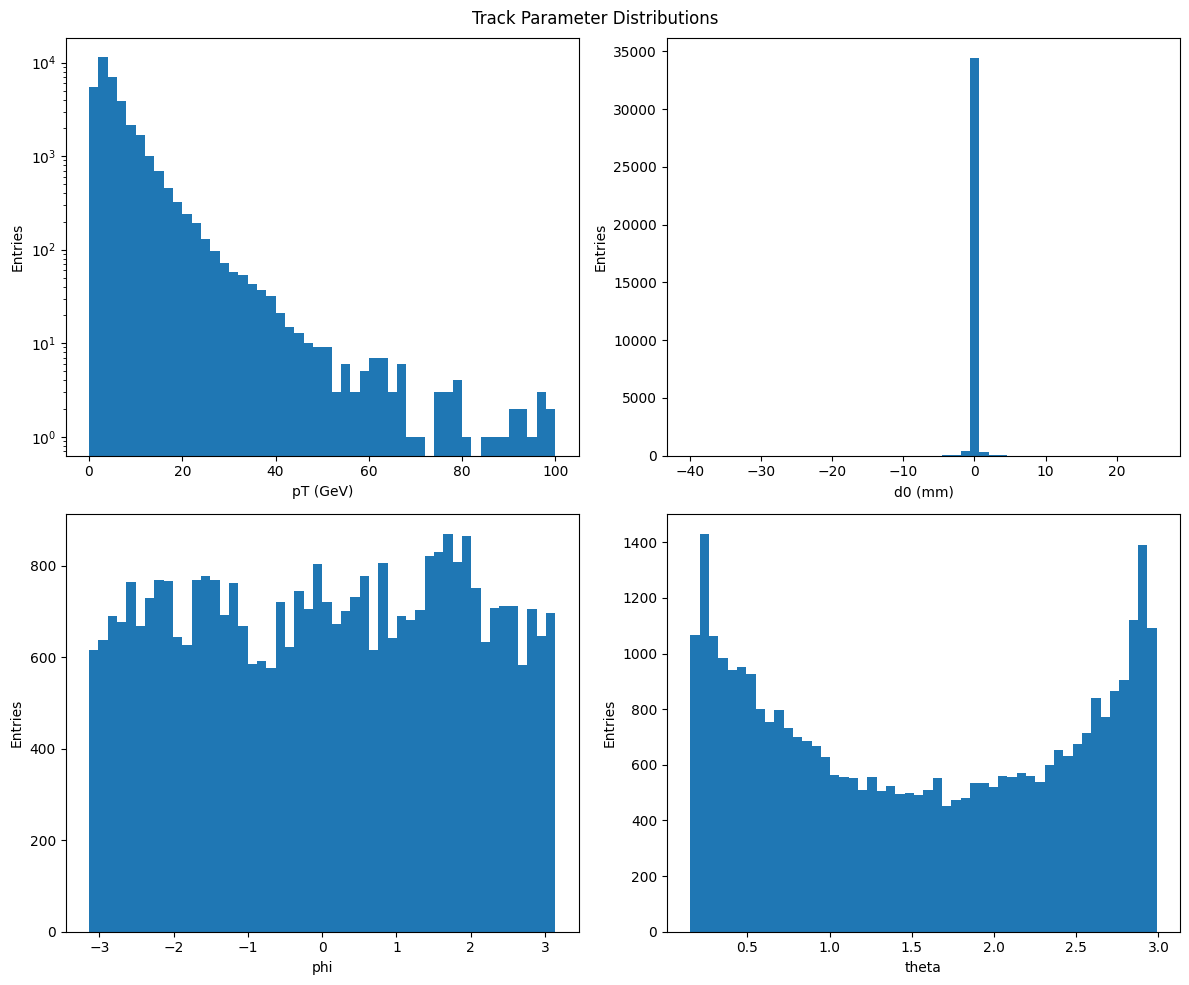

In [7]:


def flatten_and_clean_arrays(arrays: List[np.ndarray]) -> np.ndarray:
    """
    Flatten jagged arrays and remove empty arrays.
    
    Args:
        arrays: List of arrays, some of which may be empty
    Returns:
        Flattened array with non-empty values
    """
    # Filter out empty arrays and flatten
    valid_arrays = [arr for arr in arrays if len(arr) > 0]
    if not valid_arrays:
        return np.array([])
    return np.concatenate(valid_arrays)

def extract_track_data(file_path: str) -> Optional[Dict[str, np.ndarray]]:
    """
    Extract track information from ATLAS PHYSLITE data.
    
    Args:
        file_path: Path to ROOT file
    Returns:
        Dictionary containing track parameters
    """
    try:
        with uproot.open(file_path) as file:
            tree = file["CollectionTree;1"]
            
            # Track parameters to extract
            track_branches = {
                "d0": "InDetTrackParticlesAuxDyn.d0",
                "z0": "InDetTrackParticlesAuxDyn.z0",
                "phi": "InDetTrackParticlesAuxDyn.phi",
                "theta": "InDetTrackParticlesAuxDyn.theta",
                "qOverP": "InDetTrackParticlesAuxDyn.qOverP",
                "chiSquared": "InDetTrackParticlesAuxDyn.chiSquared",
                "numberDoF": "InDetTrackParticlesAuxDyn.numberDoF"
            }
            
            track_data = {}
            
            # Read and process each branch
            for param_name, branch in track_branches.items():
                try:
                    arrays = tree[branch].array(library="np")
                    flat_data = flatten_and_clean_arrays(arrays)
                    track_data[param_name] = flat_data
                    
                    if len(flat_data) > 0:
                        print(f"\n{param_name}:")
                        print(f"  Total entries: {len(flat_data)}")
                        print(f"  Non-zero entries: {np.count_nonzero(flat_data)}")
                        print(f"  Mean: {np.mean(flat_data):.6f}")
                        print(f"  Std Dev: {np.std(flat_data):.6f}")
                        
                except Exception as e:
                    print(f"Could not process {param_name}: {str(e)}")
            
            # Calculate derived quantities
            if all(key in track_data for key in ['qOverP', 'theta']):
                pT = calculate_pt_with_units(
                    track_data['qOverP'],
                    track_data['theta']
                )
                track_data['pT'] = pT
                
                print("\npT (GeV):")
                print(f"  Total entries: {len(pT)}")
                print(f"  Mean: {np.mean(pT):.2f}")
                print(f"  Std Dev: {np.std(pT):.2f}")
                print(f"  Range: [{np.min(pT):.2f}, {np.max(pT):.2f}]")
            
            # Create visualization of track distributions
            try:
                import matplotlib.pyplot as plt
                
                fig, axes = plt.subplots(2, 2, figsize=(12, 10))
                fig.suptitle('Track Parameter Distributions')
                
                # pT distribution (log scale)
                if 'pT' in track_data:
                    axes[0,0].hist(track_data['pT'], bins=50, range=(0, 100))
                    axes[0,0].set_xlabel('pT (GeV)')
                    axes[0,0].set_ylabel('Entries')
                    axes[0,0].set_yscale('log')
                
                # d0 distribution
                if 'd0' in track_data:
                    axes[0,1].hist(track_data['d0'], bins=50)
                    axes[0,1].set_xlabel('d0 (mm)')
                    axes[0,1].set_ylabel('Entries')
                
                # phi distribution
                if 'phi' in track_data:
                    axes[1,0].hist(track_data['phi'], bins=50)
                    axes[1,0].set_xlabel('phi')
                    axes[1,0].set_ylabel('Entries')
                
                # theta distribution
                if 'theta' in track_data:
                    axes[1,1].hist(track_data['theta'], bins=50)
                    axes[1,1].set_xlabel('theta')
                    axes[1,1].set_ylabel('Entries')
                
                plt.tight_layout()
                plt.savefig('track_distributions.png')
                print("\nCreated visualization: track_distributions.png")
                
            except Exception as e:
                print(f"Could not create visualizations: {str(e)}")
            
            return track_data
            
    except Exception as e:
        print(f"Error processing file: {str(e)}")
        return None

# Run the analysis
file_path = "atlas_data/catalogs/Run_00296939_catalog_0.root"
track_data = extract_track_data(file_path)